In [98]:
from collections import defaultdict
from dataclasses import replace
from dnadb import dna, fasta, sample, taxonomy
from lmdbm import Lmdb
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from pathlib import Path
import pickle
import re
import seaborn as sns
import sys
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Optional
import wandb

In [2]:
sys.path.append("../src")
from deepdna.nn.data_generators import SampleGenerator, _encode_sequences
from deepdna.nn.metrics import f1_score, positive_predictive_value, negative_predictive_value
from deepdna.nn.models import load_model, setbert

In [3]:
# tfu.devices.select_cpu()
tfu.devices.select_gpu(1)

2023-06-22 07:16:24.117816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 07:16:24.118062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 07:16:24.266204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 07:16:24.266568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 07:16:24.266850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')])

In [4]:
output_path = Path("/home/dwl2x/work/Datasets/Walker_Alex")
output_path.mkdir(exist_ok=True)

In [5]:
fasta_path = Path("/home/shared/walker_lab/alex/P_A_221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.pick.opti_mcc.0.03.pick.0.03.abund.0.03.pick.fasta")
otu_list_path = Path("/home/shared/walker_lab/digitalocean/Alex_SFD/shared_list/221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.asv.list")
otu_shared_path = Path("/home/shared/walker_lab/digitalocean/Alex_SFD/shared_list/221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.asv.shared")
metadata_path = Path("/home/shared/walker_lab/alex/230320_sfdspatial_meta_clean.csv")

## FASTA DB

In [6]:
def clean_entry(entry: fasta.FastaEntry):
    sequence = re.sub(r"[^" + dna.ALL_BASES + r"]", "", entry.sequence)
    return replace(entry, sequence=sequence)

In [7]:
# factory = fasta.FastaDbFactory(output_path / "alex.fasta.db")
# for entry in tqdm(map(clean_entry, fasta.entries(fasta_path))):
#     if len(entry) < 250:
#         continue
#     factory.write_entry(entry)
# factory.close()

In [8]:
fasta_db = fasta.FastaDb(output_path / "alex.fasta.db")

---

## Sample OTU Index

In [9]:
# with open(otu_list_path) as f:
#     keys = f.readline().strip().split('\t')
#     values = f.readline().strip().split('\t')
# otu_index = dict(zip(keys[2:], values[2:]))

In [10]:
# list(otu_index.values())[:5]

In [11]:
# factory = fasta.FastaIndexDbFactory(output_path / "alex.fasta.index.db")
# for i, asv in enumerate(tqdm(otu_index)):
#     fasta_id = otu_index[asv]
#     if fasta_id not in fasta_db:
#         continue
#     factory.write_entry(fasta_db[fasta_id], key=asv)
# factory.close()

In [12]:
index_db = fasta.FastaIndexDb(output_path / "alex.fasta.index.db")

---

## Load Metadata

In [13]:
metadata = pd.read_csv(metadata_path, index_col=0)
metadata

,taxon,ecomode,oo_present,date,county,site,clinical_signs,log_copy_number,gpsn,gpsw,...,swab_col,DNA_con,swab_plate_n,notes,richness,shannon,evenness,simpson,invsimpson,dis.sev
swab_label,,,,,,,,,,,,,,,,,,,,,
STP582C,Agkistrodon piscivorus,Aquatic,0,6/7/2015,Polk,Ouachita National Forest,NaN,0.00000,34.46294,-93.99638,...,1.0,3.06,1.0,Walker et al. ISME,618,4.804865,0.197578,0.974111,38.627160,Neg
STP633C,Crotalus horridus,Terrestrial,0,6/8/2015,Polk,Ouachita National Forest,NaN,0.00000,34.46262,-93.99853,...,1.0,2.18,1.0,Walker et al. ISME,486,4.505452,0.186233,0.962531,26.688501,Neg
STP634C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Polk,Ouachita National Forest,NaN,0.00000,34.57593,-94.03164,...,1.0,40.80,1.0,Walker et al. ISME,456,2.743417,0.034079,0.723965,3.622725,Neg
STP639C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Montgomery,Ouachita National Forest,NaN,0.00000,34.43632,-93.78750,...,1.0,3.90,1.0,Walker et al. ISME,659,4.919205,0.207730,0.975840,41.391414,Neg
STP640C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Montgomery,Ouachita National Forest,NaN,0.00000,34.43632,-93.78750,...,1.0,6.14,1.0,Walker et al. ISME,384,4.312839,0.194407,0.963434,27.347450,Neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STP1502C,Nerodia sipedon,Aquatic,1,NaN,Overton,Waterloo Falls,NaN,0.30103,NaN,NaN,...,11.0,22.60,2.0,Walker et al. ISME,692,4.422581,0.120392,0.959926,24.954109,Low
STP1503C,Nerodia sipedon,Aquatic,1,NaN,Overton,Waterloo Falls,NaN,0.30103,NaN,NaN,...,11.0,22.60,2.0,Walker et al. ISME,823,5.162691,0.212192,0.980217,50.549217,Low
STP762C,Thamnophis sirtalis,Terrestrial,1,NaN,Cumberland,Catoosa WMA,NaN,1.00000,NaN,NaN,...,2.0,23.20,1.0,Walker et al. ISME - Austin Property-Crossville,739,4.925323,0.186379,0.979888,49.721213,Low


In [14]:
# metadata_sample_names = set(metadata.index.to_list())

---

## Sample Mapping

In [15]:
# with open(otu_shared_path) as f:
#     header = f.readline().strip().split('\t')
#     lines = [line.strip().split('\t') for line in tqdm(f)]
# len(lines)

In [16]:
# cols = [i for i in range(3, len(header)) if index_db.contains_key(header[i])]

In [17]:
# header[:5]

In [18]:
# index_db.key_to_fasta_id("ASV0000004")

In [19]:
# indices = [i for i in tqdm(range(3, len(header))) if index_db.contains_key(header[i])]

In [20]:
# fasta_ids = {i: index_db.key_to_fasta_id(header[i]) for i in tqdm(indices)}

In [21]:
# factory = sample.SampleMappingDbFactory(output_path / "alex.fasta.mapping.db")
# for row in tqdm(lines):
#     sample_name = row[1]
#     if sample_name not in metadata_sample_names:
#         continue
#     sample_factory = sample.SampleMappingEntryFactory(sample_name, index_db)
#     for i in indices:
#         if (count := int(row[i])) == 0:
#             continue
#         fasta_id = fasta_ids[i]
#         sample_factory.add_entry(fasta_db[fasta_id], count)
#     factory.write_entry(sample_factory.build())
# factory.close()

In [22]:
mapping = sample.SampleMappingDb(output_path / "alex.fasta.mapping.db", index_db)

In [23]:
sample_names = set([sample.name for sample in mapping])
len(sample_names)

737

## Taxonomy

In [24]:
tax_data = pd.read_csv("/home/shared/walker_lab/alex/230428_SFDtaxfinal_engineer.csv")
tax_data

,otu,kingdom,phylum,class,order,family,genus
0,Otu000002,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Intrasporangiaceae,Janibacter
1,Otu000003,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcaceae,Deinococcus
2,Otu000004,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Burkholderiaceae_unclassified
3,Otu000005,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter
4,Otu000006,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Burkholderiaceae_unclassified
...,...,...,...,...,...,...,...
25047,Otu069105,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria_unclassified,Gammaproteobacteria_unclassified,Gammaproteobacteria_unclassified
25048,Otu069123,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Enterobacteriaceae_unclassified
25049,Otu069172,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Microbacteriaceae,Microbacteriaceae_unclassified
25050,Otu069191,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Betaproteobacteriales_unclassified,Betaproteobacteriales_unclassified


In [25]:
tax_dict = {}
for _, row in tax_data.iterrows():
    otu, taxons = row[0], taxonomy.join_taxonomy(tuple(row.values[1:]))
    tax_dict[otu] = taxons

In [26]:
tax_dict["Otu000002"]

'k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Janibacter'

In [27]:
asv_to_otu = {}
for entry in fasta_db:
    otu_id = entry.extra.split()[1]
    assert otu_id.startswith("Otu")
    asv_to_otu[entry.identifier] = otu_id
len(asv_to_otu)

1883435

---

## Pathogen Load TSVs

In [28]:
# with open(output_path / "alex.pathogen_load.tsv", "w") as f:
#     f.write(f"label\tpathogen_load\n")
#     for index, row in metadata.iterrows():
#         if index not in sample_names:
#             continue
#         f.write(f"{index}\t{row['log_copy_number']}\n")

---

## Data Generator

In [29]:
# p = pd.read_csv(output_path / "alex.pathogen_load.tsv", sep="\t", index_col=0)
# p

In [30]:
from typing import Generic, TypeVar

_T = TypeVar("_T")

class SampleTargetGenerator(SampleGenerator, Generic[_T]):
    def __init__(
        self,
        samples: Iterable[sample.SampleInterface],
        targets: dict[str, _T],
        sequence_length: int,
        kmer: int = 1,
        subsample_size: int|None = None,
        augment_slide: bool = True,
        augment_ambiguous_bases: bool = True,
        batch_size: int = 32,
        batches_per_epoch: int = 100,
        class_weights: Optional[npt.ArrayLike] = None,
        shuffle: bool = True,
        balance: bool = False,
        rng: np.random.Generator = np.random.default_rng()
    ):
        super().__init__(
            samples=samples,
            sequence_length=sequence_length,
            kmer=kmer,
            subsample_size=subsample_size,
            augment_slide=augment_slide,
            augment_ambiguous_bases=augment_ambiguous_bases,
            batch_size=batch_size,
            batches_per_epoch=batches_per_epoch,
            class_weights=class_weights,
            shuffle=shuffle,
            balance=balance,
            rng=rng
        )
        self.targets = targets

    def generate_batch(self, rng: np.random.Generator):
        subsample_size = self.subsample_size or 1
        sequence_ids = [None] * self.batch_size
        sequences = np.empty((self.batch_size, subsample_size), dtype=f"<U{self.sequence_length}")
        targets = []
        sample_names = []
        samples = self.sample_sampler.sample(self.batch_size, self.balance, rng)
        for i, sample in enumerate(samples):
            sample_names.append(sample.name)
            sequence_ids[i], sequences[i] = zip(*self.sequence_sampler.sample_with_ids(sample, subsample_size, rng))
            targets.append(self.targets[sample.name])
        sequences = _encode_sequences(sequences, self.augment_ambiguous_bases, self.rng)
        if self.subsample_size is None:
            sequences = np.squeeze(sequences, axis=1) # type: ignore
        if self.kmer > 1:
            sequences = dna.encode_kmers(sequences, self.kmer, not self.augment_ambiguous_bases)
        x, y = sequences.astype(np.int32), np.array(targets, dtype=np.float32)
        return sample_names, sequence_ids, x, y

    def reduce_batch(self, batch):
        return batch[2:]

## Construct Training/Validation Sets

In [31]:
rng = np.random.default_rng(0)

In [32]:
samples = [sample.DemultiplexedFastaSample(fasta_db, entry) for entry in mapping]

In [33]:
targets = pd.read_csv(output_path / "alex.pathogen_load.tsv", sep="\t", index_col=0)["pathogen_load"].astype(np.float32).to_dict()

In [34]:
rng.shuffle(samples)
# split_index = int(0.2*len(samples))
split_index = 0
train_samples = samples[split_index:]
# val_samples = samples[:split_index]
val_samples = train_samples

train_targets = {sample.name: targets[sample.name] for sample in train_samples}
val_targets = {sample.name: targets[sample.name] for sample in val_samples}
len(train_targets), len(val_targets)

(737, 737)

In [35]:
def compute_class_weights(samples, targets):
    negative_indices = np.array([1.0 if targets[sample.name] == 0.0 else 0.0 for sample in samples])
    positive_indices = 1 - negative_indices
    negative_weights = negative_indices / np.sum(negative_indices)
    positive_weights = positive_indices / np.sum(positive_indices)
    class_weights = positive_weights/2 + negative_weights/2
    return class_weights

In [36]:
# Test (should be ~= 500)
sum([train_targets[s.name] > 0.0 for s in rng.choice(train_samples, 1000, p=compute_class_weights(train_samples, train_targets))])

/tmp/ipykernel_1408483/3560127358.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sum([train_targets[s.name] > 0.0 for s in rng.choice(train_samples, 1000, p=compute_class_weights(train_samples, train_targets))])


485

In [37]:
train_targets = {k: int(v > 0) for k, v in train_targets.items()}
val_targets = {k: int(v > 0) for k, v in val_targets.items()}

In [38]:
common_args = dict(
    sequence_length = 250,
    kmer = 3,
    subsample_size = 1000,
    batch_size=16
)

train_dataset = SampleTargetGenerator(
    train_samples,
    train_targets,
    class_weights=compute_class_weights(train_samples, train_targets),
    batches_per_epoch=20,
    **common_args
)

val_dataset = SampleTargetGenerator(
    val_samples,
    val_targets,
    class_weights=compute_class_weights(val_samples, val_targets),
    batches_per_epoch=16,
    shuffle=False,
    **common_args
)

In [39]:
train_dataset[0]

(array([[[40, 34, 10, ...,  5, 22, 26],
         [49,  6, 26, ..., 24, 32,  1],
         [ 6, 26, 40, ..., 32,  1,  5],
         ...,
         [44, 50, 10, ...,  6, 26, 42],
         [49,  6, 24, ..., 16,  0,  1],
         [ 6, 27, 44, ..., 32,  1,  4]],
 
        [[ 6, 27, 44, ..., 32,  1,  4],
         [27, 44, 50, ...,  1,  4, 18],
         [44, 50, 10, ...,  4, 18, 10],
         ...,
         [49,  6, 27, ..., 24, 32,  1],
         [26, 40, 34, ...,  1,  4, 18],
         [27, 44, 50, ...,  1,  4, 18]],
 
        [[26, 40, 34, ...,  1,  5, 22],
         [ 6, 26, 40, ..., 32,  1,  5],
         [49,  6, 26, ..., 24, 32,  1],
         ...,
         [49,  6, 27, ..., 16,  0,  1],
         [18,  8, 34, ...,  1,  4, 18],
         [49,  6, 26, ..., 16,  0,  1]],
 
        ...,
 
        [[ 6, 26, 40, ..., 32,  1,  5],
         [26, 40, 34, ...,  1,  5, 22],
         [49,  6, 26, ..., 24, 32,  1],
         ...,
         [49,  6, 27, ..., 24, 32,  1],
         [49,  6, 27, ..., 24, 32,  1],


## Loss Functions

In [40]:
def log_norm_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    epsilon = 1e-8 # can't compute log of 0
    l_mu, l_sigma = tf.unstack(y_pred, axis=-1)
    # l_mu = tf.expand_dims(l_mu,-1)
    # l_sigma = tf.expand_dims(l_sigma,-1)

    t1 = tf.math.log(l_sigma)
    t2 = tf.math.log(y_true + epsilon)
    t3 = tf.math.log(2.0)/2.0
    t4 = tf.math.log(np.pi)/2.0
    t5 = tf.math.pow(l_mu-tf.math.log(y_true),2.0) / (2.0 * tf.math.pow(l_sigma,2.0))

    loss_ = t1+t2+t3+t4+t5
    return loss_

In [41]:
def norm_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    l_sigma = 1.0
    # l_mu, l_sigma = tf.unstack(y_pred, axis=-1)
    l_mu = y_pred
    # l_mu = tf.expand_dims(l_mu,-1)
    # l_sigma = tf.expand_dims(l_sigma,-1)

    t1 = tf.math.log(l_sigma)
    t2 = tf.math.log(2.0)/2.0
    t3 = tf.math.log(np.pi)/2.0
    t4 = tf.math.pow(l_mu-y_true,2.0) / (2.0 * tf.math.pow(l_sigma,2.0))

    loss_ = t1+t2+t3+t4
    return loss_

In [42]:
def rayleigh_dist_loss(y_true, y_pred):
    l_y, l_sigma = tf.unstack(y_pred, axis=-1)

    t1 = 2*tf.math.log(l_sigma)
    t2 = -tf.math.log(l_y)
    t3 = l_y**2/(2*l_sigma**2)

    loss_ = t1+t2+t3
    return loss_

In [43]:
# def to_bool(x):
#     if x.dtype == tf.bool:
#         return x
#     return x > 0.5

# def true_positives(y_true, y_pred, dtype=tf.int32):
#     # x and y
#     return tf.reduce_sum(tf.cast(tf.logical_and(y_pred, y_true), dtype=dtype))

# def true_negatives(y_true, y_pred, dtype=tf.int32):
#     # x' and y' == (x or y)'
#     return tf.reduce_sum(tf.cast(tf.logical_not(tf.logical_or(y_pred, y_true)), dtype=dtype))

# def false_positives(y_true, y_pred, dtype=tf.int32):
#     # x and y'
#     return tf.reduce_sum(tf.cast(tf.logical_and(y_pred, tf.logical_not(y_true)), dtype=dtype))

# def false_negatives(y_true, y_pred, dtype=tf.int32):
#     # x' and y
#     return tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(y_pred), y_true), dtype=dtype))

# def positive_predictive_value(y_true, y_pred):
#     y_true = to_bool(y_true)
#     y_pred = to_bool(y_pred)

#     tp = true_positives(y_true, y_pred, tf.float32)
#     fp = false_positives(y_true, y_pred, tf.float32)

#     return tf.math.divide_no_nan(tp, tp + fp)

## Model Architecture

In [44]:
api = wandb.Api()
# run = wandb.init(project="setbert-pathogen-load", name="binary-classification")

In [45]:
path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
# path = run.use_artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
setbert_encoder = setbert.SetBertEncoderModel(
    load_model(path, setbert.SetBertPretrainModel).base,
    auto_build=False
)
setbert_encoder.base.dnabert_encoder.chunk_size = 256

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v0, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1
2023-06-21 19:48:24.589418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 19:48:24.591330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 19:48:24.591571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 19:48:24.591760: I tensorflow/stream_exe

In [47]:
# y = x = tf.keras.layers.Input((1000, 248))
# y = setbert_encoder(y)
# y = tf.keras.layers.Dense(1, activation="sigmoid", name="y")(y)
# # sigma = tf.keras.layers.Dense(1, activation="softplus", name="sigma")(y)
# # y = tf.keras.layers.Concatenate(-1)((mu, sigma))
# model = tf.keras.Model(x, y)
# model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(),
#         tf.keras.metrics.Precision(name="precision_ppv"),
#         tf.keras.metrics.Recall(),
#         f1_score,
#         negative_predictive_value
#     ],
#     optimizer=tf.keras.optimizers.Adam(1e-4)
# )
# model.summary()

In [48]:
# wandb_callback = wandb.keras.WandbCallback(save_model=False)
# wandb_callback.save_model_as_artifact = False

# checkpoint = tf.keras.callbacks.ModelCheckpoint("models/setbert_alex_bce", monitor="f1_score", save_best=True)

In [49]:
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=20,
#     initial_epoch=10,
#     callbacks=[wandb_callback, checkpoint]
# )

In [50]:
# wandb.finish()

In [44]:
api = wandb.Api()

In [45]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
setbert_encoder_pretrained = setbert.SetBertEncoderModel(
    load_model(path, setbert.SetBertPretrainModel).base
)
setbert_encoder_pretrained.base.dnabert_encoder.chunk_size = 256

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v0, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.2
2023-06-22 07:16:44.735141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 07:16:44.742281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 07:16:44.742583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 07:16:44.742813: I tensorflow/stream_exe

In [46]:
setbert_encoder = load_model("./setbert_alex_bce")

In [51]:
# trained_predictions = setbert_encoder(train_dataset[0][0], return_attention_scores=True)
# untrained_predictions = setbert_encoder_pretrained(train_dataset[0][0], return_attention_scores=True)

trained_predictions = setbert_encoder(val_dataset[0][0], return_attention_scores=True)
untrained_predictions = setbert_encoder_pretrained(val_dataset[0][0], return_attention_scores=True)

2023-06-21 19:51:52.146483: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.

KeyboardInterrupt



In [55]:
len(trained_predictions[1])

1

In [56]:
len(trained_predictions[1][0])

8

In [57]:
# trained_predictions[1][0][0][0]

In [58]:
# untrained_predictions[1][0][0][0]

In [59]:
attention_scores = []
for i in range(len(trained_predictions[1][0])):
    attention_scores.append(trained_predictions[1][0][i].numpy() - untrained_predictions[1][0][i].numpy())
    # attention_scores.append(trained_predictions[1][0][i].numpy())
attention_scores = np.array(attention_scores)
attention_scores.shape

(8, 16, 8, 1001, 1001)

In [60]:
len(attention_scores)

8

In [61]:
attention_scores[0][0][0].shape

(1001, 1001)

In [62]:
attention_scores[0][0][0][0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [63]:
attention_scores[0][0][0][0].shape

(1001,)

In [64]:
attention_scores.shape

(8, 16, 8, 1001, 1001)

In [65]:
train_dataset[0][1]

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [66]:
attention_scores[1][0][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [70]:
index = 2

<AxesSubplot:>

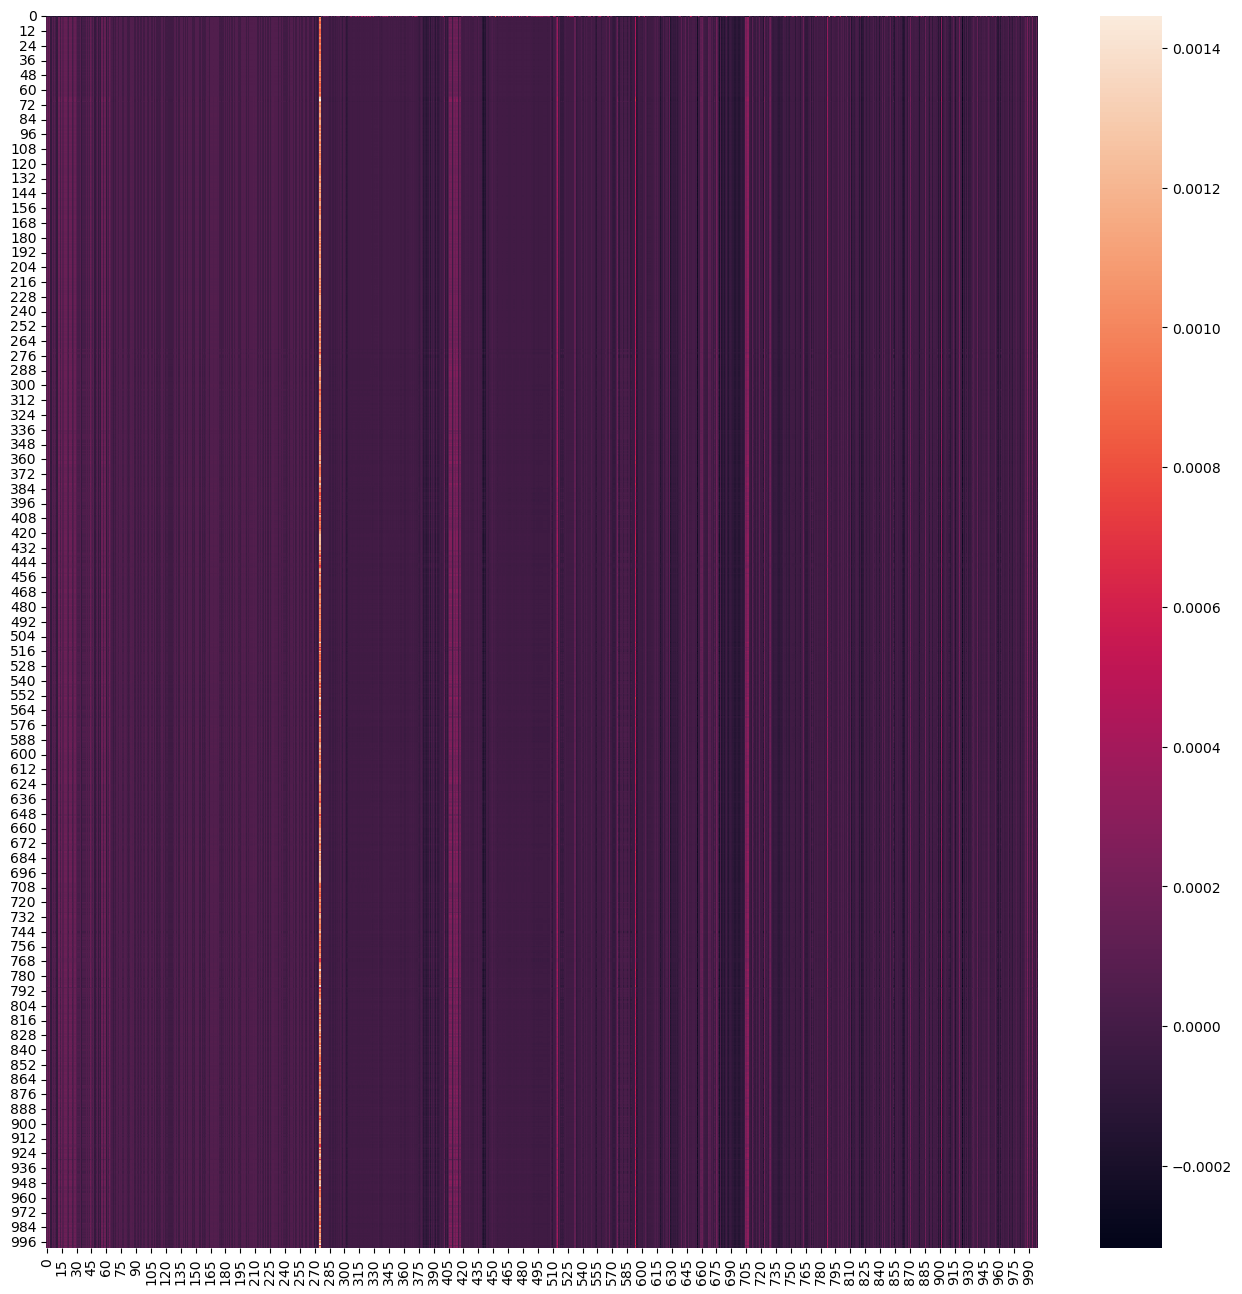

In [71]:
plt.figure(figsize=(16, 16))
sns.heatmap(attention_scores[0][index][6][:,1:])

In [72]:
a = []
for i in range(len(attention_scores)):
    a.append(np.sum(attention_scores[i][index], axis=(0, 1)))
a = np.array(a)[:,1:]
a.shape

(8, 1000)

In [73]:
# np.savetxt("attention_scores.txt", a)

Text(50.722222222222214, 0.5, 'Transformer Block')

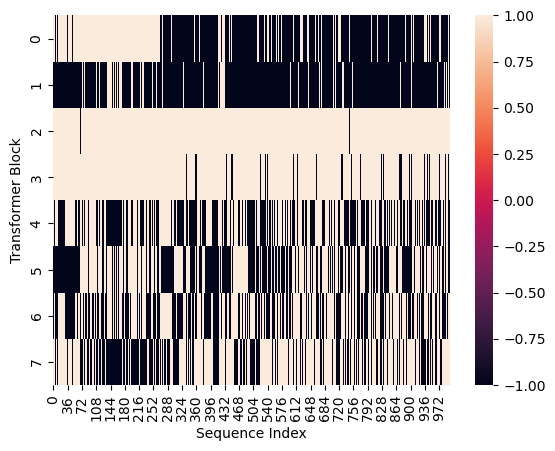

In [74]:
sns.heatmap(np.sign(a))
plt.xlabel("Sequence Index")
plt.ylabel("Transformer Block")

In [114]:
tdata = a.sum(0) # a.copy()
sorted_indices = np.argsort(tdata)[::-1]
tdata.shape
# tdata[np.where(np.abs(tdata) < 50)] = 0.0

(1000,)

In [127]:
batch_index = 0
index = 2

In [129]:
print("Is present:", val_dataset.get(batch_index)[3][index])

Is present: 1.0


In [133]:
tdata[sorted_indices[:20]]

array([96.21557 , 66.90698 , 62.063248, 57.093185, 57.093185, 51.6347  ,
       45.66148 , 38.548935, 32.55419 , 29.89124 , 28.528635, 28.41715 ,
       27.910433, 27.454433, 25.66349 , 25.112377, 24.25325 , 23.784433,
       23.292881, 22.95972 ], dtype=float32)

In [95]:
positive_samples = {}
negative_samples = {}
for s in samples:
    if targets[s.name] > 0.0:
        positive_samples[s.name] = s
    else:
        negative_samples[s.name] = s
len(positive_samples), len(negative_samples)

(190, 547)

In [67]:
# sequence_embeddings = {}
# for i, s in enumerate(samples):
#     print(f"\r{i+1}/{len(samples)}", end="")
#     g = SampleTargetGenerator([s], {s.name: 1}, sequence_length=250, kmer=3, subsample_size=1000, batch_size=10, batches_per_epoch=1)
#     _, fasta_ids, sequences, _ = g.get(0)
#     embeddings = setbert_encoder.base.dnabert_encoder.encode(sequences, chunk_size=256)
#     sequence_embeddings[s.name] = {
#         "fasta_ids": fasta_ids,
#         "sequences": embeddings
#     }
# with open("./alex_sequence_embeddings.pkl", 'wb') as f:
#     pickle.dump(sequence_embeddings, f)

In [73]:
with open("./alex_sequence_embeddings.pkl", 'rb') as f:
    sequence_embeddings = pickle.load(f)

In [105]:
infected_tax_scores = [defaultdict(int) for _ in range(8)] # scores for each transformer block
uninfected_tax_scores = [defaultdict(int) for _ in range(8)]
for i, (name, batch) in enumerate(sequence_embeddings.items()):
    print(f"\r{i+1}/{len(sequence_embeddings)}", end="")
    pretrained = np.array(setbert_encoder_pretrained(batch["sequences"], return_attention_scores=True)[1][0]).astype(np.float64)
    finetuned = np.array(setbert_encoder(batch["sequences"], return_attention_scores=True)[1][0]).astype(np.float64)
    scores = finetuned[:,:,:,1:,1:] - pretrained[:,:,:,1:,1:] # remove class token
    # aggregate heads
    scores = np.sum(scores, axis=2)
    tax_score_blocks = infected_tax_scores if name in positive_samples else uninfected_tax_scores
    for tax_scores, block in zip(tax_score_blocks, scores):
        for asvs, batch_scores in zip(batch["fasta_ids"], block):
            batch_scores = batch_scores.sum(0)
            for index in np.argsort(batch_scores):
                tax_scores[tax_dict[asv_to_otu[asvs[index]]]] += batch_scores[index] / len(block)
with open("./alex_attention_scores.pkl", 'wb') as f:
    pickle.dump((infected_tax_scores, uninfected_tax_scores), f)

737/737

In [125]:
with open("./alex_attention_scores.pkl", 'rb') as f:
    old_infected_tax_scores, old_uninfected_tax_scores = pickle.load(f)

In [138]:
infected_tax_scores = [defaultdict(int) for _ in range(8)] # scores for each transformer block
uninfected_tax_scores = [defaultdict(int) for _ in range(8)]
for i in range(len(old_infected_tax_scores)):
    for asv, score in old_infected_tax_scores[i].items():
        infected_tax_scores[i][tax_dict[asv_to_otu[asv]]] += score

In [145]:
infected_tax_scores_aggregated = defaultdict(int)
for i in range(len(infected_tax_scores)):
    for tax, score in infected_tax_scores[i].items():
        infected_tax_scores_aggregated[tax] += score

In [142]:
for i in range(len(infected_tax_scores)):
    print(f"Block {i+1}:")
    for tax, score in sorted(infected_tax_scores[i].items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {score:<20}", tax)

Block 1:
  6805.251982506365    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__Burkholderiaceae; g__Burkholderiaceae_unclassified
  4935.555215589601    k__Bacteria; p__Deinococcus-Thermus; c__Deinococci; o__Deinococcales; f__Deinococcaceae; g__Deinococcus
  3772.393982229202    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Beijerinckiaceae; g__Methylobacterium
  1750.9248490613347   k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Flavobacteriales; f__Weeksellaceae; g__Chryseobacterium
  1376.385244683485    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus
  772.6687543517713    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Caulobacterales; f__Caulobacteraceae; g__Brevundimonas
  501.69360524592287   k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Cytophagales; f__Hymenobacteraceae; g__Hymenobacter
  341.3943450416159    k__Bacteria; p__Prote

In [150]:
for tax, score in sorted(infected_tax_scores_aggregated.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{score:<20}", tax)

44079.292219416806   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Janibacter
28106.031965042854   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__Burkholderiaceae; g__Burkholderiaceae_unclassified
23679.814820387954   k__Bacteria; p__Deinococcus-Thermus; c__Deinococci; o__Deinococcales; f__Deinococcaceae; g__Deinococcus
19390.512771190246   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides
16672.99606549455    k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Cytophagales; f__Hymenobacteraceae; g__Hymenobacter
13916.832056666735   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Micrococcales_unclassified; g__Micrococcales_unclassified
10580.16612281264    k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Intrasporangiaceae_unclassified
9009.366229785377    k__Bacteria; p__

In [148]:
for i in range(len(infected_tax_scores)):
    print(f"Block {i+1}:")
    for tax, score in sorted(infected_tax_scores[i].items(), key=lambda x: x[1], reverse=False)[:10]:
        print(f"  {score:<20}", tax)

Block 1:
  -1973.0533590150676  k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Intrasporangiaceae; g__Janibacter
  -1719.234028552387   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides
  -1701.8217023821906  k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas
  -941.4234551659179   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Marmoricola
  -898.6969155289246   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas
  -894.5979761731625   k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Micrococcales; f__Micrococcales_unclassified; g__Micrococcales_unclassified
  -891.6289015449937   k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Fusobacteriaceae; g__Cetobacterium
  -741.1856773137469   k__Bacteria;

In [149]:
for tax, score in sorted(infected_tax_scores_aggregated.items(), key=lambda x: x[1])[:10]:
    print(f"{score:<20}", tax)

-12521.26095235978   k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus
-11824.22714938279   k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas
-6198.892838740079   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas
-3239.227425721593   k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Enterobacteriaceae_unclassified
-1646.213529788185   k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Rhodobacteraceae_unclassified
-1214.1730336100873  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Proteus
-1140.6291831468463  k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Rubellimicrobium
-1018.6728294816197 

In [ ]:
ranked_taxa[:20]

['k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Paracoccus; s__',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__Burkholderiaceae; g__Burkholderiaceae_unclassified; s__',
 'k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Propionibacteriales; f__Nocardioidaceae; g__Nocardioides; s__',
 'k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Rhizobiaceae; g__Rhizobiaceae_unclassified; s__',
 'k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Acetobacterales; f__Acetobacteraceae; g__Belnapia; s__',
 'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Cytophagales; f__Spirosomaceae; g__Dyadobacter; s__',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Betaproteobacteriales; f__SC-I-84; g__SC-I-84_unclassified; s__',
 'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Cytophagales; f__Spirosomaceae; g__Spirosomaceae_unclassified; s__',
 'k__Bacteria; p